In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
from src.data import data as data_utils
from src.data import players_score_data as players_score_data_utils
from src.ml import model as model_utils
from run import scripts
import torch
from torch import nn
from torch import optim
from torch.optim import lr_scheduler

torch.manual_seed(2002);

In [8]:
train_dataloader, val_dataloader, test_dataloader = data_utils.dataloaders(name='elephant', x_version=['players', 'teams'], y_version='score', train_split=0.8, val_split=0.1, test_split=0.1, batch_size=32, engineered=True)

/Users/sharshe/Documents/TBN/src/data/data.py:327: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(dataloaders_path)


In [9]:
x, y = next(iter(train_dataloader))

len(padded_inputs_list) 1
len(padded_inputs) 2
2


IndexError: list index out of range

In [31]:
train_dataloader, val_dataloader, test_dataloader = data_utils.dataloaders(name='elephant', x_version=['players'], y_version='score', train_split=0.8, val_split=0.1, test_split=0.1, batch_size=32)

/Users/sharshe/Documents/TBN/src/data/data.py:313: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(dataloaders_path)


In [28]:
train_dataloader, val_dataloader, test_dataloader = data_utils.dataloaders(name='elephant', x_version='players', y_version='score', train_split=0.8, val_split=0.1, test_split=0.1, batch_size=32)

elephant_players_score_0.8_0.1_0.1_32


Exception: keep going!

In [27]:
x, y = next(iter(train_dataloader))

NameError: name 'train_dataloader' is not defined

In [101]:
cfg_dict = {
    'name': 'hannibal',
    'dataset_name': 'elephant',
    'x_version': 'players',
    'y_version': 'player_score',
    'batch_size': 32,
    'train_split': 0.8,
    'val_split': 0.1,
    'test_split': 0.1,
    'n_epochs': 50,
    'loss_fn': 'MSELoss',
    'optimizer': 'Adam',
    'scheduler': 'ReduceLROnPlateau',
    'model': 'PlayerScoreModel',
    'd_mod': 64
}

In [102]:
train_dataloader, val_dataloader, test_dataloader = players_score_data_utils.dataloaders(name=cfg_dict['dataset_name'], train_split=cfg_dict['train_split'], val_split=cfg_dict['val_split'], test_split=cfg_dict['test_split'], batch_size=cfg_dict['batch_size'])

/Users/sharshe/Documents/TBN/src/data/players_score_data.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  


In [106]:
model = model_utils.PlayerScoreModel(d_in=65, d_mod=cfg_dict['d_mod'])

In [107]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=4)
loss_fn = nn.MSELoss()

wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


EPOCH 1 OF 50 | hannibal | TRAIN MEAN LOSS: 0.026309 | VAL MEAN LOSS: 0.004785
EPOCH 2 OF 50 | hannibal | TRAIN MEAN LOSS: 0.004706 | VAL MEAN LOSS: 0.004637
EPOCH 3 OF 50 | hannibal | TRAIN MEAN LOSS: 0.004546 | VAL MEAN LOSS: 0.005458
EPOCH 4 OF 50 | hannibal | TRAIN MEAN LOSS: 0.004493 | VAL MEAN LOSS: 0.004303
EPOCH 5 OF 50 | hannibal | TRAIN MEAN LOSS: 0.004474 | VAL MEAN LOSS: 0.004831
EPOCH 6 OF 50 | hannibal | TRAIN MEAN LOSS: 0.004458 | VAL MEAN LOSS: 0.004308
EPOCH 7 OF 50 | hannibal | TRAIN MEAN LOSS: 0.004462 | VAL MEAN LOSS: 0.004268
EPOCH 8 OF 50 | hannibal | TRAIN MEAN LOSS: 0.004387 | VAL MEAN LOSS: 0.004386
EPOCH 9 OF 50 | hannibal | TRAIN MEAN LOSS: 0.004341 | VAL MEAN LOSS: 0.004178
EPOCH 10 OF 50 | hannibal | TRAIN MEAN LOSS: 0.004385 | VAL MEAN LOSS: 0.004796
EPOCH 11 OF 50 | hannibal | TRAIN MEAN LOSS: 0.004304 | VAL MEAN LOSS: 0.004173
EPOCH 12 OF 50 | hannibal | TRAIN MEAN LOSS: 0.004311 | VAL MEAN LOSS: 0.005507
EPOCH 13 OF 50 | hannibal | TRAIN MEAN LOSS: 0.00

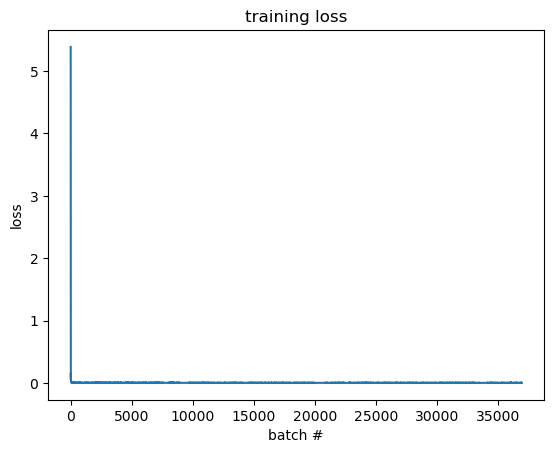

TEST MEAN LOSS: 0.048795
TEST ACCURACY: 0.624238


learning_rate,█████████████▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_accuracy,▁
test_mean_loss,▁
train_mean_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_loss,▅▄█▂▅▂▂▁▅▁▂▂▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
learning_rate,0.0
test_accuracy,0.62424
test_mean_loss,0.04879
train_mean_loss,0.00409
val_mean_loss,0.0041


In [108]:
scripts.train_test(model=model, train_dataloader=train_dataloader, val_dataloader=val_dataloader, test_dataloader=test_dataloader, cfg_dict=cfg_dict, loss_fn=loss_fn, optimizer=optimizer, scheduler=scheduler)

In [ ]:
``